--- Part 1: Loading and Preprocessing the MNIST Dataset ---
Normalized training data shape: (60000, 28, 28, 1)
Example of a normalized pixel value: -1.0

--- Part 2: Building the GAN Components ---

--- Generator Model Summary ---



--- Discriminator Model Summary ---



--- Beginning GAN Training ---
Epoch 1/2 - Generator Loss: 0.7307, Discriminator Loss: 1.0874
Epoch 2/2 - Generator Loss: 0.7997, Discriminator Loss: 1.2802

--- Training complete. Generating final images. ---


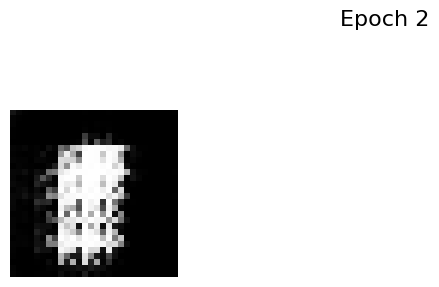

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import os

# Suppress TensorFlow warnings for cleaner output
tf.keras.utils.disable_interactive_logging()

# --- Part 1: Dataset Loading and Preprocessing ---

print("--- Part 1: Loading and Preprocessing the MNIST Dataset ---")

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Reshape images to (28, 28, 1) and convert to float32
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

# Normalize pixel values to [-1, 1]
x_train = (x_train - 127.5) / 127.5

print(f"Normalized training data shape: {x_train.shape}")
print("Example of a normalized pixel value:", x_train[0, 0, 0, 0])

# --- Part 2: Building the Generator and Discriminator Models ---

print("\n--- Part 2: Building the GAN Components ---")

latent_dim = 100  # Size of the noise vector

def build_generator():
    model = keras.Sequential(name="generator")
    # Project and reshape
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 7x7 -> 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 14x14 -> 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final layer: output image with tanh activation (range [-1,1])
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
print("\n--- Generator Model Summary ---")
generator.summary()

def build_discriminator():
    model = keras.Sequential(name="discriminator")
    # Downsample
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Real or fake output

    return model

discriminator = build_discriminator()
print("\n--- Discriminator Model Summary ---")
discriminator.summary()

# --- Part 3: Loss Functions, Optimizers, and Training ---

cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

batch_size = 256

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions_rescaled = (predictions * 0.5) + 0.5  # Scale back to [0,1]

    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions_rescaled[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}", fontsize=16)

    if not os.path.exists('images'):
        os.makedirs('images')
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.show()

EPOCHS = 2
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, latent_dim])

# Prepare dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)

def train(dataset, epochs):
    print("\n--- Beginning GAN Training ---")
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss.numpy())
            disc_loss_list.append(disc_loss.numpy())

        avg_gen_loss = np.mean(gen_loss_list)
        avg_disc_loss = np.mean(disc_loss_list)

        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.4f}, "
              f"Discriminator Loss: {avg_disc_loss:.4f}")

        if (epoch + 1) % 20 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

    print("\n--- Training complete. Generating final images. ---")
    generate_and_save_images(generator, epochs, seed)

# Run training
train(train_dataset, EPOCHS)
